![](./images/header.png)

# 1. Introduction
In this notebook we'll start from a time series of Sentinel-2 data over an agricultural area in Malawi, located in between the towns of Nkhotakota in the east and Kasungu in the west. We will demonstrate some parcel-based crop monitoring applications, including:

- field delineation
- phenology (growing season) detection

Let's first have a look at the Sentinel-2 data and make it ready for further processing...

# 2. Preparing the Sentinel-2 data

We have prepared two netCDF files containing data spanning a full growing season: October 2022 until end of July 2023. One netCDF file contains the 10 m resolution bands, the other one contains the 20 m resolution data.

Pre-processing these data will consist of the following steps:
- masking clouds based on the Sentinel-2 scene classification layer
- 10-daily compositing, or in other words making sure we have one observation every 10 days
- interpolation of no data to make sure we have a continuous time series without any gaps

In [1]:
# Import the necessary python libraries...
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries

# import custom python functions all defined in separate .py files
# custom functions
from rescale import rescale_ts
from mask import mask_ts
from composite import composite_ts
from interpolate import interpolate_ts
from features import tsteps
from phenology import (detect_seasons, visualize_seasons)

In [2]:
# We start by loading the scene classification layer, containing information about the presence of clouds
# This is delivered at 20m resolution, so we open the 20m resolution file
# infile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/s2_data/36LWL/30/S2-L2A_20m_36LWL-30_32736_2022-10-01_2023-08-01.nc'
infile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/s2_data/36LWL/30/S2-L2A_20m_36LWL-30_32736_2022-10-01_2023-08-01.nc'
ds = xr.open_dataset(infile)
# inspect the contents of the file
ds

<xarray.Dataset>
Dimensions:              (timestamp: 113, y: 512, x: 512)
Coordinates:
    spatial_ref          int64 ...
  * timestamp            (timestamp) datetime64[ns] 2022-10-03T07:47:51 ... 2...
  * x                    (x) float64 5.819e+05 5.819e+05 ... 5.921e+05 5.921e+05
  * y                    (y) float64 8.58e+06 8.58e+06 ... 8.569e+06 8.569e+06
Data variables:
    B05                  (timestamp, y, x) float32 ...
    B06                  (timestamp, y, x) float32 ...
    B07                  (timestamp, y, x) float32 ...
    B11                  (timestamp, y, x) float32 ...
    B12                  (timestamp, y, x) float32 ...
    SCENECLASSIFICATION  (timestamp, y, x) float32 ...
Attributes:
    block:         30
    bounds:        [ 581900 8569300  592140 8579540]
    crs:           +init=epsg:32736
    end_date:      2023-08-01
    epsg:          32736
    grid_mapping:  spatial_ref
    name:          S2-L2A_20m_36LWL-30
    resolution:    20
    start_date:    2022-10-01
    tile:          36LWL

So in this file there are 6 variables and each variable consists of a 3-dimensional array (time, x, y). There are 113 available dates in the time series and we have a total of 512 x 512 (=262,144) pixels available.
Let's plot some data to get a sense on how the data looks like...

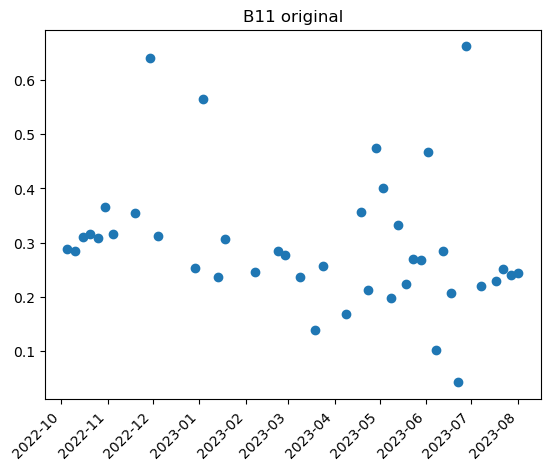

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot the first SWIR band (B11) for one pixel:
fig, ax = plt.subplots()
# in the next line of code, we select B11,
# convert it to a data array and then extract
# all its values for pixel located at position x=200, y=200
b11 = ds[['B11']].to_array().values[0, :, 200, 200]
# extract the timestamps
time = ds.coords['timestamp'].values
# plot B11 vs time
ax.plot(time, b11, '-o')
plt.xticks(rotation=45, ha='right')
plt.title('B11 original')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/b11.png')

As you can tell from the figure above, the signal looks quite messy and requires some further cleaning before proceeding with any analysis.

We will first process the 20 m data, then upsample the data to 10m so it can be combined with the 10 m data.

First step will be cloud masking. For this, we need the scene classification band, which is available at 20m resolution...

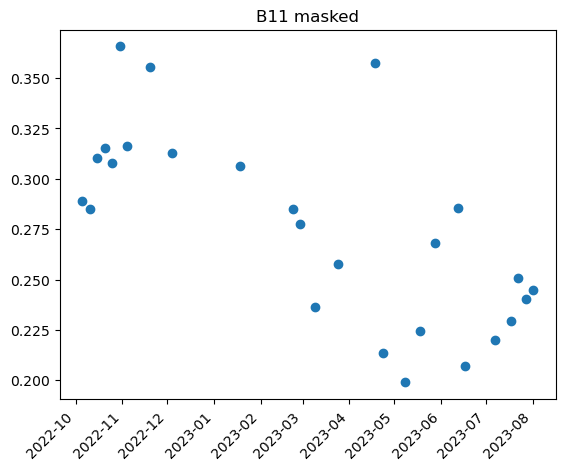

<Figure size 640x480 with 0 Axes>

In [4]:
# We convert it to a data array for further processing...
scl_20 = ds[['SCENECLASSIFICATION']].to_array()

# within the scene classification layer, the following values point
# to clouds/shadows:
scl_mask_values = [1, 3, 8, 9, 10, 11]

# create mask (True = not to be masked, False = to be masked)
mask_20 = np.logical_not(scl_20.isin(scl_mask_values))
mask_20.attrs = scl_20.attrs.copy()

# NOTE that the quality of the scene classification layer for sentinel-2 is not always optimal.
# Several enhancements are possible before applying this layer for masking. An example can be found here:m
# https://github.com/dzanaga/satio-pc/blob/main/satio_pc/preprocessing/clouds.py#L60
# This is however beyond the scope of this exercise.

# Get the 20 m bands from the file
ts_20 = ds[['B05', 'B06', 'B07', 'B11', 'B12']].to_array()

# Apply the mask to the data
ts_20_masked = mask_ts(ts_20, mask_20)

# Plot the result for the same pixel plotted earlier.
fig, ax = plt.subplots()
b11 = ts_20_masked.sel(variable='B11').values[:, 200, 200]
time = ds.coords['timestamp'].values
ax.plot(time, b11, '-o')
plt.xticks(rotation=45, ha='right')
plt.title('B11 masked')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/b11_msk.png')

Compare this plot with the earlier plot. What changed?

Now that we got rid of (most) clouds, let's proceed with the next step.
Now we create a 10-daily summary of the data through temporal compositing.
The result of this step will be that you end up with a time series having one observation every 10 days.
Each observation is the median of all available observations within the 10 day window.
This makes the time series more uniform (number of available observations highly depends on the location!)

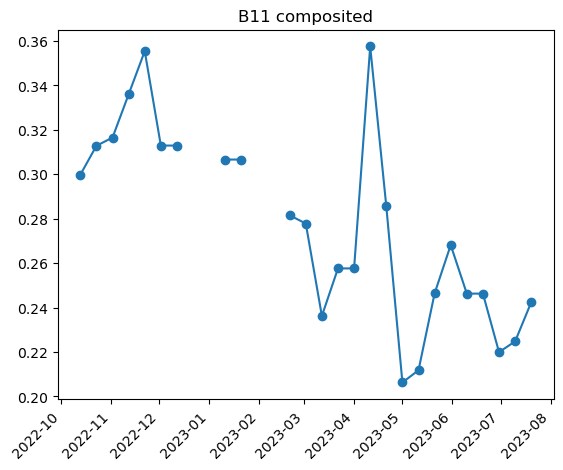

<Figure size 640x480 with 0 Axes>

In [5]:
# apply compositing to the timeseries
# (have a look in composite.py to learn what happens)
ts_20_comp = composite_ts(ts_20_masked, freq=10, window=20, mode='median')

# plot the result for our pixel:
fig, ax = plt.subplots()
b11 = ts_20_comp.sel(variable='B11').values[:, 200, 200]
time = ts_20_comp.coords['timestamp'].values
ax.plot(time, b11, '-o')
plt.xticks(rotation=45, ha='right')
plt.title('B11 composited')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/b11_comp.png')

Again, compare this one with the previous graph and reflect on what happened.

As a final step, we linearly interpolate any remaining gaps in the time series (for some 10 day windows, there was not a single valid observation as can be seen as interruptions of the graph above).

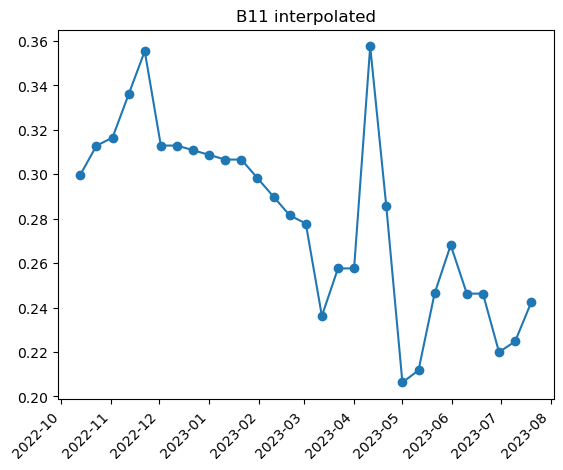

<Figure size 640x480 with 0 Axes>

In [6]:
# apply interpolation to the time series
# (have a look in interpolate.py to learn what happens in the background)
ts_20_intp = interpolate_ts(ts_20_comp)

# plot the result for our pixel:
fig, ax = plt.subplots()
b11 = ts_20_intp.sel(variable='B11').values[:, 200, 200]
time = ts_20_comp.coords['timestamp'].values
ax.plot(time, b11, '-o')
plt.xticks(rotation=45, ha='right')
plt.title('B11 interpolated')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/b11_interp.png')

This is the result of the pre-processing to ensure smooth, un-interrupted time series. 
Finally, we upsample the 20m data to 10 m resolution...

In [7]:
ts_20_fin = rescale_ts(ts_20_intp, scale=2, order=0)
ts_20_fin

# (notice how the x and y dimensions have doubled!)

<xarray.DataArray (variable: 5, timestamp: 29, y: 1024, x: 1024)>
array([[[[0.22285   , 0.22285   , 0.21884999, ..., 0.2189    ,
          0.19534999, 0.19534999],
         [0.22285   , 0.22285   , 0.21884999, ..., 0.2189    ,
          0.19534999, 0.19534999],
         [0.2129    , 0.2129    , 0.20664999, ..., 0.22915   ,
          0.20054999, 0.20054999],
         ...,
         [0.16665   , 0.16665   , 0.16659999, ..., 0.2276    ,
          0.23995   , 0.23995   ],
         [0.162     , 0.162     , 0.16615   , ..., 0.22219999,
          0.22549999, 0.22549999],
         [0.162     , 0.162     , 0.16615   , ..., 0.22219999,
          0.22549999, 0.22549999]],

        [[0.22599998, 0.22599998, 0.22775   , ..., 0.2277    ,
          0.2039    , 0.2039    ],
         [0.22599998, 0.22599998, 0.22775   , ..., 0.2277    ,
          0.2039    , 0.2039    ],
         [0.21335   , 0.21335   , 0.21609999, ..., 0.2365    ,
          0.2069    , 0.2069    ],
...
         [0.27195   , 0.27195   , 0.25895   , ..., 0.268     ,
          0.236     , 0.236     ],
         [0.25849998, 0.25849998, 0.27225   , ..., 0.3005    ,
          0.2631    , 0.2631    ],
         [0.25849998, 0.25849998, 0.27225   , ..., 0.3005    ,
          0.2631    , 0.2631    ]],

        [[0.28794998, 0.28794998, 0.3096    , ..., 0.2546    ,
          0.2429    , 0.2429    ],
         [0.28794998, 0.28794998, 0.3096    , ..., 0.2546    ,
          0.2429    , 0.2429    ],
         [0.26874998, 0.26874998, 0.29055   , ..., 0.2598    ,
          0.251     , 0.251     ],
         ...,
         [0.2825    , 0.2825    , 0.2539    , ..., 0.2644    ,
          0.24075   , 0.24075   ],
         [0.2683    , 0.2683    , 0.27429998, ..., 0.3012    ,
          0.27359998, 0.27359998],
         [0.2683    , 0.2683    , 0.27429998, ..., 0.3012    ,
          0.27359998, 0.27359998]]]], dtype=float32)
Coordinates:
  * variable   (variable) <U3 'B05' 'B06' 'B07' 'B11' 'B12'
  * timestamp  (timestamp) datetime64[ns] 2022-10-13 2022-10-23 ... 2023-07-20
  * y          (y) float64 8.58e+06 8.58e+06 8.58e+06 ... 8.569e+06 8.569e+06
  * x          (x) float64 5.819e+05 5.819e+05 5.819e+05 ... 5.921e+05 5.921e+05
Attributes:
    block:         30
    bounds:        [ 581900 8569300  592140 8579540]
    crs:           +init=epsg:32736
    end_date:      2023-08-01
    epsg:          32736
    grid_mapping:  spatial_ref
    name:          S2-L2A_20m_36LWL-30
    resolution:    10
    start_date:    2022-10-01
    tile:          36LWL

Now it's time to move to the 10 m resolution data.
Open the associated file and go through each of the pre-processing steps as explained above:

In [9]:
# Select the correct data file and open it
infile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/s2_data/36LWL/30/S2-L2A_10m_36LWL-30_32736_2022-10-01_2023-08-01.nc'
ds = xr.open_dataset(infile)
ds

<xarray.Dataset>
Dimensions:      (timestamp: 113, y: 1024, x: 1024)
Coordinates:
    spatial_ref  int64 ...
  * timestamp    (timestamp) datetime64[ns] 2022-10-03T07:47:51 ... 2023-08-0...
  * x            (x) float64 5.819e+05 5.819e+05 ... 5.921e+05 5.921e+05
  * y            (y) float64 8.58e+06 8.58e+06 8.58e+06 ... 8.569e+06 8.569e+06
Data variables:
    B02          (timestamp, y, x) float32 ...
    B03          (timestamp, y, x) float32 ...
    B04          (timestamp, y, x) float32 ...
    B08          (timestamp, y, x) float32 ...
Attributes:
    block:         30
    bounds:        [ 581900 8569300  592140 8579540]
    crs:           +init=epsg:32736
    end_date:      2023-08-01
    epsg:          32736
    grid_mapping:  spatial_ref
    name:          S2-L2A_10m_36LWL-30
    resolution:    10
    start_date:    2022-10-01
    tile:          36LWL

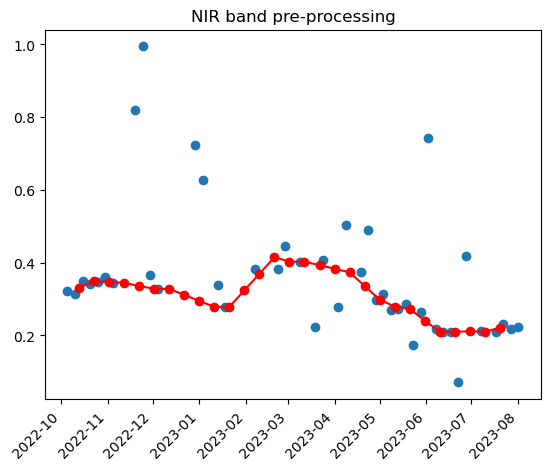

<Figure size 640x480 with 0 Axes>

In [10]:
# convert the mask to 10 m resolution
mask_10 = rescale_ts(mask_20, scale=2, order=0)

# Get the 10 m bands from the file
ts_10 = ds[['B02', 'B03', 'B04', 'B08']].to_array()

# Apply the mask to the data
ts_10_masked = mask_ts(ts_10, mask_10)

# Apply temporal compositing
ts_10_comp = composite_ts(ts_10_masked, freq=10, window=20, mode='median')

# Apply linear interpolation
ts_10_fin = interpolate_ts(ts_10_comp)
ts_10_fin

# plot comparison between original NIR band and the result of pre-processing
fig, ax = plt.subplots()
b08 = ts_10.sel(variable='B08').values[:, 200, 200]
time = ds.coords['timestamp'].values
ax.plot(time, b08, '-o')
time = ts_10_fin.coords['timestamp'].values
b08 = ts_10_fin.sel(variable='B08').values[:, 200, 200]
ax.plot(time, b08, '-or')
plt.xticks(rotation=45, ha='right')
plt.title('NIR band pre-processing')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/b08_preproc.png')


In [16]:
# As a final step, we merge all bands together
ts_fin = xr.concat([ts_10_fin, ts_20_fin], dim='variable')
ts_fin

NameError: name 'ts_10_fin' is not defined

In [ ]:
# And we free up some memory before proceeding...
del ts_20, ts_20_fin, ts_20_comp, ts_20_intp, ts_20_masked
del ts_10, ts_10_fin, ts_10_comp, ts_10_masked

# 3. Computation of vegetation indices
Now that we have our data ready to go, let's compute a well-known vegetation index used as a basis for many agricultural monitoring applications, i.e. the NDVI.

In [14]:
# Compute NDVI
# isolate the NIR band (B08)
b08 = ts_fin.sel(variable='B08').values
# isolate the RED band (B04)
b04 = ts_fin.sel(variable='B04').values
# compute the index
ndvi = (b08 - b04) / (b08 + b04)
ndvi.shape

# note that the result is a 3D matrix with 29 time steps and 1024 x 1024 pixels

(29, 1024, 1024)

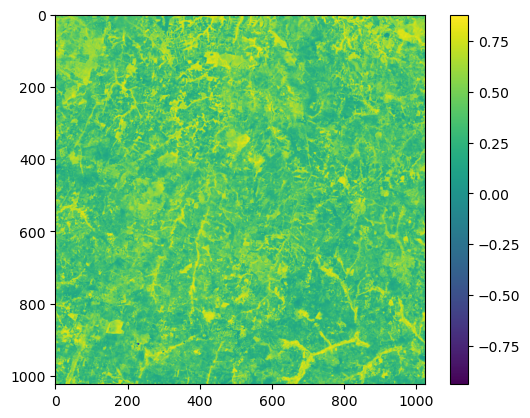

<Figure size 640x480 with 0 Axes>

In [15]:
# Visualize spatially for one particular date
# (we select the 11th available date)
fig, ax = plt.subplots()
ndviplot = plt.imshow(ndvi[10, ...])
fig.colorbar(ndviplot, ax=ax)
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/ndvi_image.png')

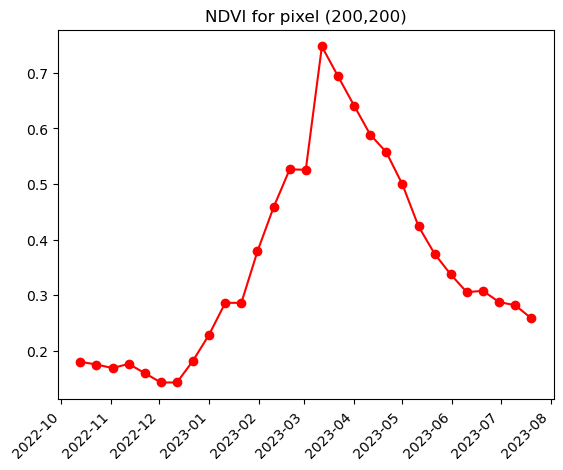

<Figure size 640x480 with 0 Axes>

In [17]:
# Visualize temporally for one pixel
# retrieve the time coordinate
time = ts_fin.coords['timestamp'].values

# now plot the time series for our pixel located at position 200,200
fig, ax = plt.subplots()
ax.plot(time, ndvi[:, 200, 200], '-or')
plt.xticks(rotation=45, ha='right')
plt.title('NDVI for pixel (200,200)')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/ndvi_timeseries.png')


# 4. Field delineation
We can use the temporal profile of NDVI to recognize and delineate individual fields in the landscape (different crops behave differently throughout the season). This is illustrated in the following example.

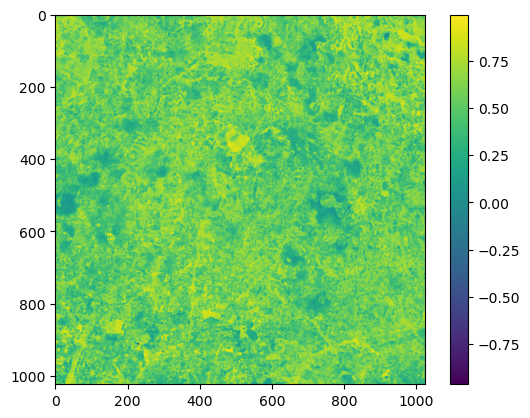

<Figure size 640x480 with 0 Axes>

In [18]:
# Clip a portion from the image to limit processing for this demo:
ndvi_sub = ndvi[:, 0:200, 0:200]
fig, ax = plt.subplots()
ndviplot = plt.imshow(ndvi[12, ...])
fig.colorbar(ndviplot, ax=ax)
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/ndvi_sub.png')


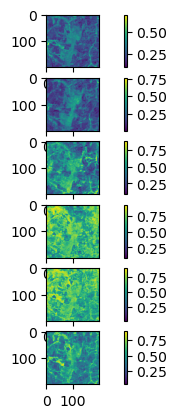

<Figure size 640x480 with 0 Axes>

In [23]:
# Resample NDVI temporally to six equidistant timesteps
# (this means we summarize the temporal profile from originally 29 values into six values)
ndvi_tsteps = tsteps(ndvi_sub)

# plot these 6 timesteps
fig, ax = plt.subplots(6, 1)
for i in range(6):
    feat_plt = ax[i].imshow(np.squeeze(ndvi_tsteps[i, ...]))
    fig.colorbar(feat_plt, ax=ax[i])
plt.show()
plt.savefig(
    f'/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/ndvi_sub_tstep{i}.png')


The segmentation algorithm we will be using for this demonstration can only use 3 inputs. So we select visually from the above plots the time steps we believe provide most information to correctly delineate individual fields in the image.

NOTE that other possiblities include to start from all original time steps and condense the information to 3 variables using for instance principal component analysis. This is however beyond the scope of this exercise.

In [24]:
# use 3 out of 6 timesteps for parcel delineation
tsteps_selected = [1, 3, 5]
inputs = np.take(ndvi_tsteps, tsteps_selected, axis=0)
inputs = np.moveaxis(inputs, 0, -1)

# apply the Felzenzwalb segmentation algorithm
#NOTE that there are many other segmentation algorithms available in the skimage package
# Felzenszwalb is known for its decent results in combination with
# minimal requirements regarding parameter tuning.
#NOTE that you can change the size of the delineated parcels by altering the
# scale parameter in the algoritm. More information here:
# https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb
segments_fz = felzenszwalb(inputs, scale=50, sigma=0.5)
segments_fz

# the result is a raster containing the segment ID for each pixel.
# let's now visualize these results a bit better...

array([[  0,   0,   0, ...,  21,  21,  21],
       [  0,   0,   0, ...,  21,  21,  21],
       [  0,   0,   0, ...,  21,  21,  21],
       ...,
       [405, 405, 405, ..., 416, 416, 416],
       [405, 405, 405, ..., 416, 416, 416],
       [405, 405, 405, ..., 416, 416, 416]])

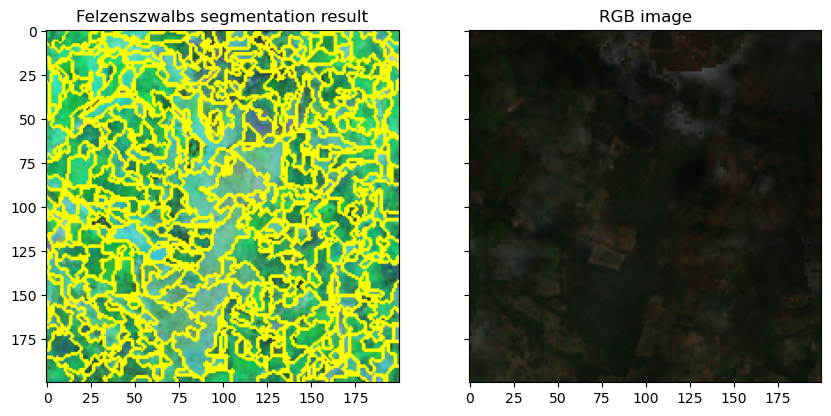

<Figure size 640x480 with 0 Axes>

In [25]:
# prepare an RGB image for visual reference
# we select timestep 13 to have an image in the middle of 
# the growing season...
rgb = ts_fin.sel(variable=['B04', 'B03', 'B02']
                    ).values[:, 12, 0:200, 0:200]
rgb = np.moveaxis(rgb, 0, -1)

# plot result
fig, ax = plt.subplots(1, 2, figsize=(10, 10),
                        sharex=True, sharey=True)
ax[0].imshow(mark_boundaries(inputs, segments_fz))
ax[0].set_title("Felzenszwalbs segmentation result")
ax[1].imshow(rgb)
ax[1].set_title('RGB image')
plt.show()
plt.savefig(
    '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/segmentation_result.png')

# (Note on the RGB image there are still some undetected clouds present 
# in the image!)

# 5. Phenology detection

Detection of growing seasons can be done on a pixel-per-pixel basis using the NDVI time series of each individual pixel OR it can be done per parcel using the segments delineated above.
Here we will showcase the latter option.

In [29]:
# compute the average NDVI profile per parcel
segment_ids = np.unique(segments_fz)
nsegments = len(segment_ids)
ntimes = ndvi_sub.shape[0]
ndvi_segm = np.zeros([ntimes, nsegments], dtype=np.float32)
for i, id in enumerate(segment_ids):
    msk = segments_fz == id
    msk_3d = np.broadcast_to(msk, ndvi_sub.shape)
    ndvi_masked = np.where(msk_3d == 1, ndvi_sub, np.nan)
    ndvi_segm[:, i] = np.nanmean(ndvi_masked, axis=(1, 2))

ndvi_segm.shape
# We now have a 2D array with 29 time steps and 425 segments

(29, 425)

In [30]:
# Now apply phenology detection on this data array
# first make sure the input shape is 3D
# (see documentation of the detect_seasons function)
ndvi_segm = np.expand_dims(ndvi_segm, axis=2)
# get the time coordinates
time = ts_fin.coords['timestamp'].values
# run phenology detection
nseas, sos, mos, eos = detect_seasons(ndvi_segm, time)

# inspect the results of the algorithm:
# nseas contains how many seasons have been identified for each pixel (or segment in our case)
# sos contains the start date of up to 5 detected seasons per pixel
# mos contains the peak date of up to 5 detected seasons per pixel
# eos contains the end date of up to 5 detected seasons per pixel

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

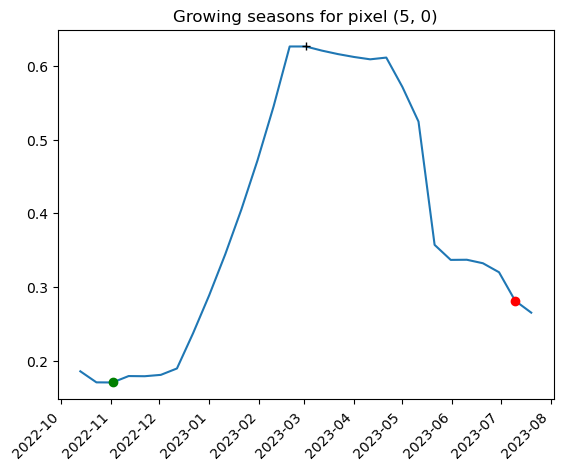

<Figure size 640x480 with 0 Axes>

In [31]:
# visualize output for one pixel
outfile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/pheno_detection.png'
x, y = 5, 0
visualize_seasons(nseas, sos, mos, eos, x, y,
                    ndvi_segm, time, outfile=outfile)

# green dot denotes the start, black '+' denotes the peak and a red dot denotes the end of the season.


END OF THE EXERCISE